O notebook abaixo extrai todas as informações necessárias para a construção do modelo.

#### Importações

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gc
from tqdm import tqdm
from fpdf import FPDF
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.impute import KNNImputer


In [2]:
map_col_func = {
        'Albumine': 'max',
        'Lactate': 'max',
        'Bicarbonate': 'min',
        'Chloride': 'max',
        'Hemoglobin': 'min',
        'Sodium': 'max',
        'Glucose': 'max',
        'Troponin':'max',
        'Platelets':'min',
        'INR': 'max',
        'Creatinine': 'max',
        'Bun': 'max',
        'Bilirubin':'max',
        'AST': 'max',
        'ALT':'max',
        'C_reactive': 'max',
        'ESR': 'max',
        'Bands': 'max',
        'WBC': 'max',
        'Oxygen_saturation':'max',
        'Temperature': 'max',
        'Systolic_pressure': 'max',
        'Respiratory_rate': 'max',
        'Heart_rate':'max'
    }

As bases 'exams_24h' e 'patients_24h' podem ser geradas através do notebook 'analysis_exams', as outras bases são originiais da MIMIC-IV ou geradas através de um script

In [40]:
exams_24h = pd.read_csv("exams_24h.csv")
patients_24h = pd.read_csv("patients_24h.csv")
gcs = pd.read_csv("/scratch/haniel.botelho/physionet.org/files/mimiciv/2.2/gcs.csv")
sofa = pd.read_csv("/scratch/haniel.botelho/physionet.org/files/mimiciv/2.2/sofa.csv")
icu_stays = pd.read_csv("/scratch/haniel.botelho/physionet.org/files/mimiciv/2.2/icu/icustays.csv")
admissions = pd.read_csv("/scratch/haniel.botelho/physionet.org/files/mimiciv/2.2/hosp/admissions.csv")
patients = pd.read_csv("/scratch/haniel.botelho/physionet.org/files/mimiciv/2.2/hosp/patients.csv")

In [4]:
sofa = pd.merge(sofa,icu_stays[['subject_id','hadm_id','stay_id']],on='stay_id',how='left')
gcs = pd.merge(gcs,icu_stays[['hadm_id','stay_id']],on='stay_id',how='left')


#### Tratamento das bases

In [5]:
sofa = sofa[['hr', 'pao2fio2ratio_novent',
       'pao2fio2ratio_vent', 'rate_epinephrine', 'rate_norepinephrine',
       'rate_dopamine', 'rate_dobutamine', 'meanbp_min', 'gcs_min', 'uo_24hr',
       'bilirubin_max', 'creatinine_max', 'platelet_min', 'respiration',
       'coagulation', 'liver', 'cardiovascular', 'cns', 'renal',
       'respiration_24hours', 'coagulation_24hours', 'liver_24hours',
       'cardiovascular_24hours', 'cns_24hours', 'renal_24hours',
       'sofa_24hours', 'subject_id', 'hadm_id']]
sofa = sofa[sofa['hr']<=24]
sofa = sofa.drop('hr',axis=1)
exams_24h = exams_24h.drop('Unnamed: 0',axis=1)


In [6]:
exams_24h = exams_24h[exams_24h["value"] != "___"]
exams_24h.dropna(inplace=True)

In [7]:
exams_24hr = exams_24h.copy()
exams_24hr['value'] = pd.to_numeric(exams_24hr['value'], errors='coerce')

#### Outliers

In [8]:
exams_24hr['log_value'] = np.log(exams_24hr['value'] + 0.00001) 

stats = exams_24hr.groupby("exam_name")['log_value'].agg(['mean', 'std'])

# Mesclar as estatísticas de volta ao DataFrame original
exams_24hr = exams_24hr.merge(stats, on="exam_name", how="left")

# Calcular os limites inferior e superior
exams_24hr['lower_bound'] = exams_24hr['mean'] - 2 * exams_24hr['std']
exams_24hr['upper_bound'] = exams_24hr['mean'] + 2 * exams_24hr['std']

# Filtrar os valores que estão dentro de 2 desvios padrão da média
exams_24h = exams_24hr[
    (exams_24hr['log_value'] >= exams_24hr['lower_bound']) &
    (exams_24hr['log_value'] <= exams_24hr['upper_bound'])
]
exams_24h.groupby("exam_name").max()

,subject_id,hadm_id,value,Sepsis,log_value,mean,std,lower_bound,upper_bound
exam_name,,,,,,,,,
ALT,19999297,29999498,639.0,sepsis3,6.459904,3.821533,1.319796,1.181941,6.461124
AST,19999297,29999498,873.0,sepsis3,6.771936,4.161836,1.305332,1.551172,6.772499
Albumine,19998878,29998193,4.7,sepsis3,1.547565,1.087373,0.232306,0.622762,1.551984
Bands,19997367,29999498,66.0,sepsis3,4.189655,-1.986635,5.999635,-13.985906,10.012636
Bicarbonate,19999840,29999809,32.0,sepsis3,3.465736,3.113240,0.186832,2.739576,3.486904
Bilirubin,19999297,29999498,10.4,sepsis3,2.341807,0.033906,1.158278,-2.282651,2.350462
Bun,19999840,29999809,102.0,sepsis3,4.624973,3.214606,0.709855,1.794897,4.634316
C_reactive,19962418,29916398,292.3,sepsis3,5.677781,4.152353,1.411754,1.328846,6.975861
Chloride,19999840,29999809,118.0,sepsis3,4.770685,4.640162,0.065487,4.509189,4.771135


#### Selecionando piores exames

In [9]:
columns_exams_min = ['Bicarbonate',
        'Hemoglobin',
        'Platelets']

exams_24h_min = exams_24h[exams_24h['exam_name'].isin(columns_exams_min)]
exams_24h_max = exams_24h[~exams_24h['exam_name'].isin(columns_exams_min)]


In [10]:
exams_24h_min['value'] = pd.to_numeric(exams_24h_min['value'], errors='coerce')

# Passo 2: Remover ou preencher valores nulos na coluna 'value'
exams_24h_min = exams_24h_min.dropna(subset=['value'])

grouped_df = exams_24h_min.groupby(['subject_id', 'hadm_id', 'exam_name'])['value'].min().reset_index()
# Passo 2: Pivotar o DataFrame para criar colunas para cada exame
pivot_df_min = grouped_df.pivot(index=['subject_id', 'hadm_id'], columns='exam_name', values='value')

# Opcional: Resetar o índice se quiser que 'subject_id' e 'hadm_id' voltem a ser colunas normais
pivot_df_min = pivot_df_min.reset_index()


/tmp/ipykernel_177047/721365644.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exams_24h_min['value'] = pd.to_numeric(exams_24h_min['value'], errors='coerce')


In [11]:
exams_24h_max['value'] = pd.to_numeric(exams_24h_max['value'], errors='coerce')

# Passo 2: Remover ou preencher valores nulos na coluna 'value'
exams_24h_max = exams_24h_max.dropna(subset=['value'])

grouped_df = exams_24h_max.groupby(['subject_id', 'hadm_id', 'exam_name'])['value'].max().reset_index()
# Passo 2: Pivotar o DataFrame para criar colunas para cada exame
pivot_df_max = grouped_df.pivot(index=['subject_id', 'hadm_id'], columns='exam_name', values='value')

# Opcional: Resetar o índice se quiser que 'subject_id' e 'hadm_id' voltem a ser colunas normais
pivot_df_max = pivot_df_max.reset_index()


/tmp/ipykernel_177047/4009422966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exams_24h_max['value'] = pd.to_numeric(exams_24h_max['value'], errors='coerce')


In [12]:
worst_exams_24h = pd.merge(pivot_df_max,pivot_df_min,on = ['subject_id','hadm_id'],how = 'left')
worst_exams_24h.max()

exam_name
subject_id           19999840.0
hadm_id              29999809.0
ALT                       639.0
AST                       873.0
Albumine                    4.7
Bands                      66.0
Bilirubin                  10.4
Bun                       102.0
C_reactive                292.3
Chloride                  118.0
Creatinine                  4.6
ESR                       150.0
Glucose                   270.0
Heart_rate                144.0
INR                         2.8
Lactate                     4.5
Oxygen_saturation         100.0
Respiratory_rate          124.0
Sodium                    147.0
Systolic_pressure         175.0
Temperature                48.2
WBC                        40.6
Bicarbonate                32.0
Hemoglobin                 15.1
dtype: float64

#### Visualizando valores

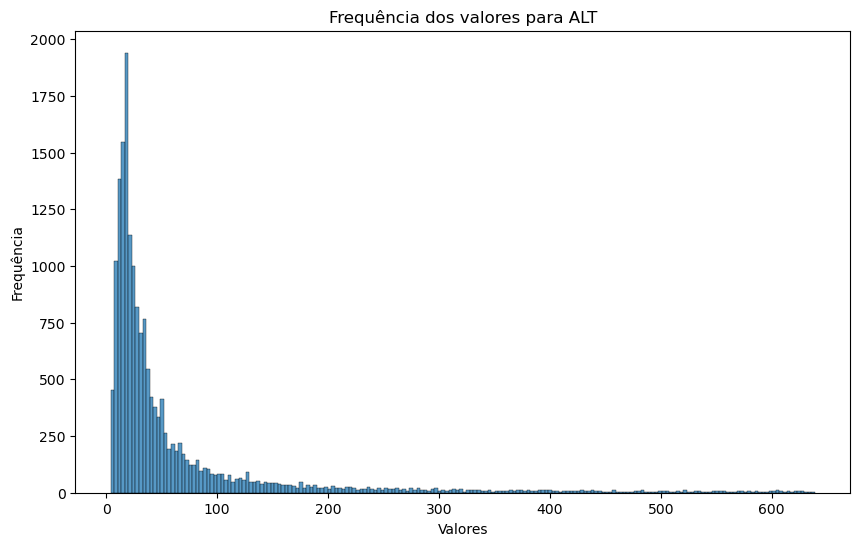

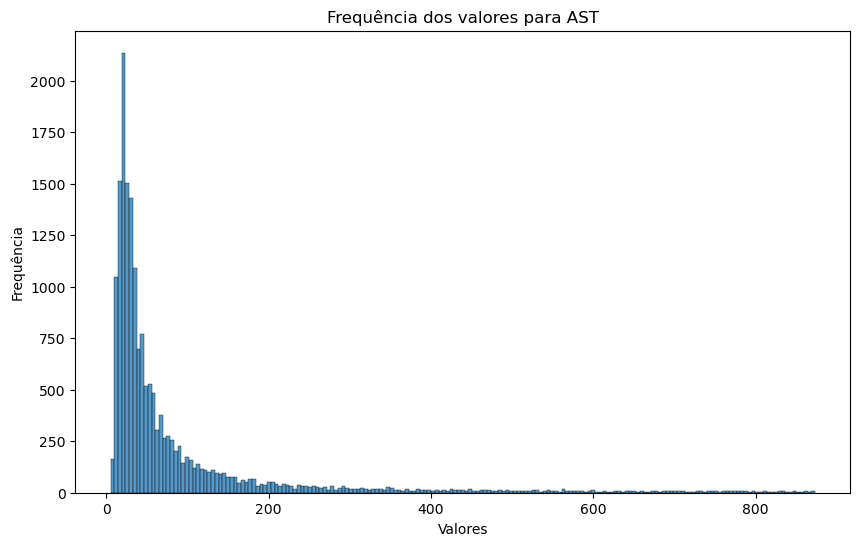

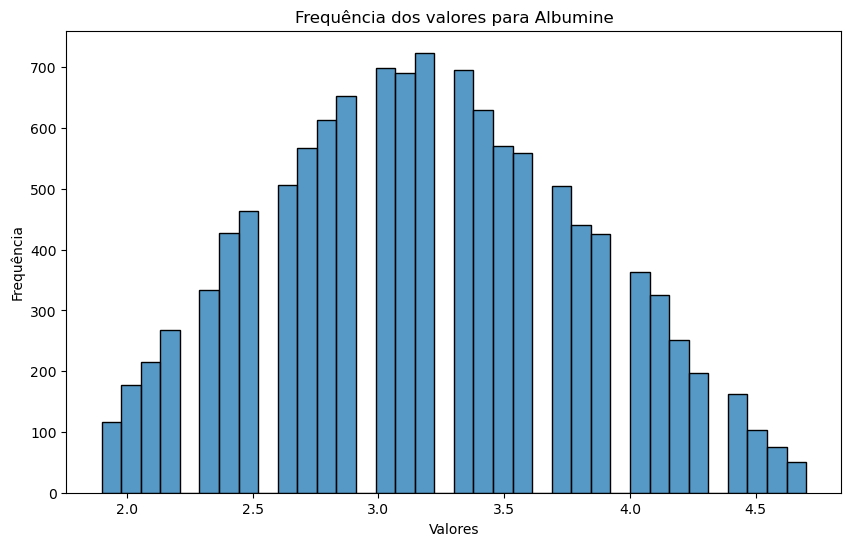

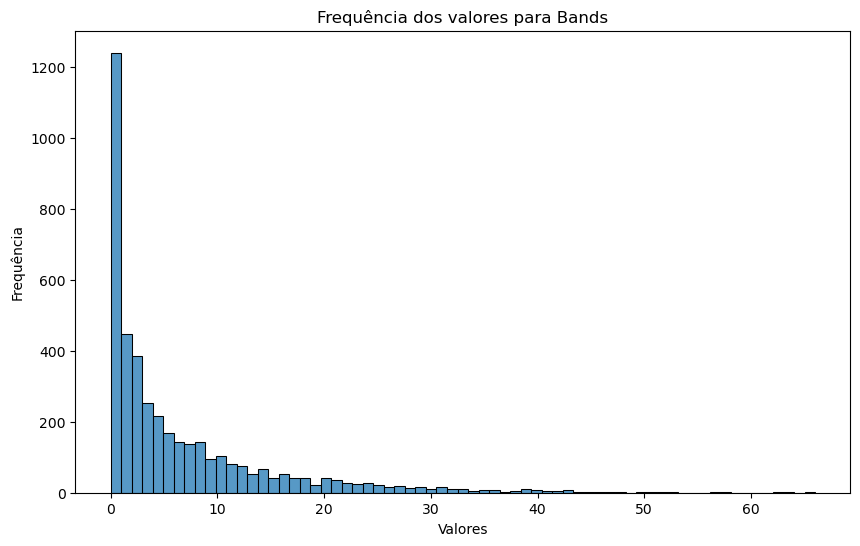

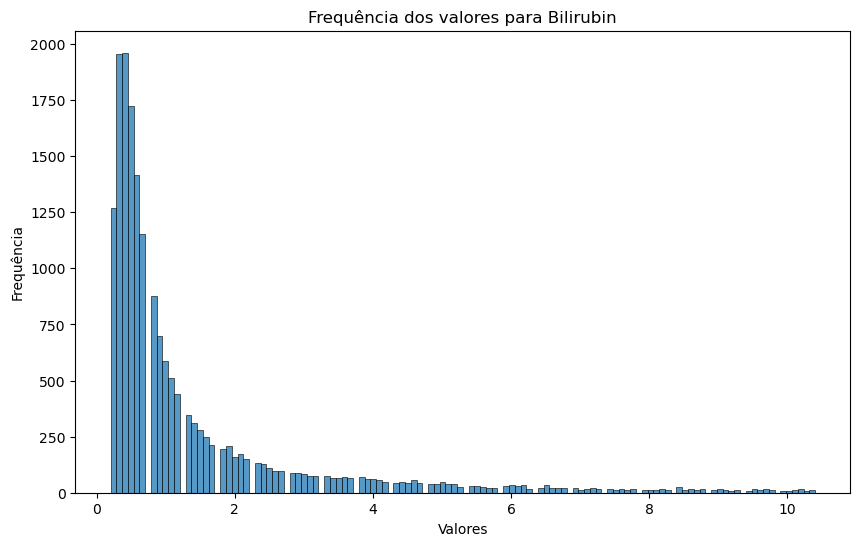

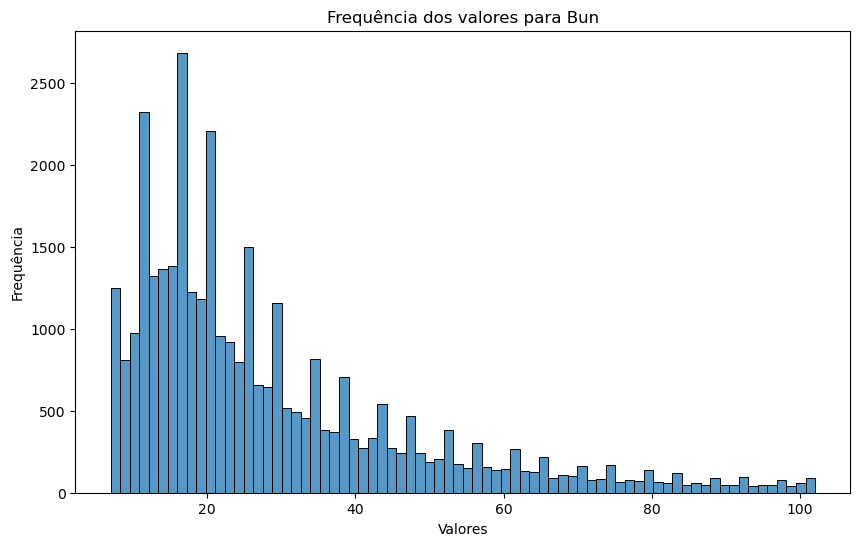

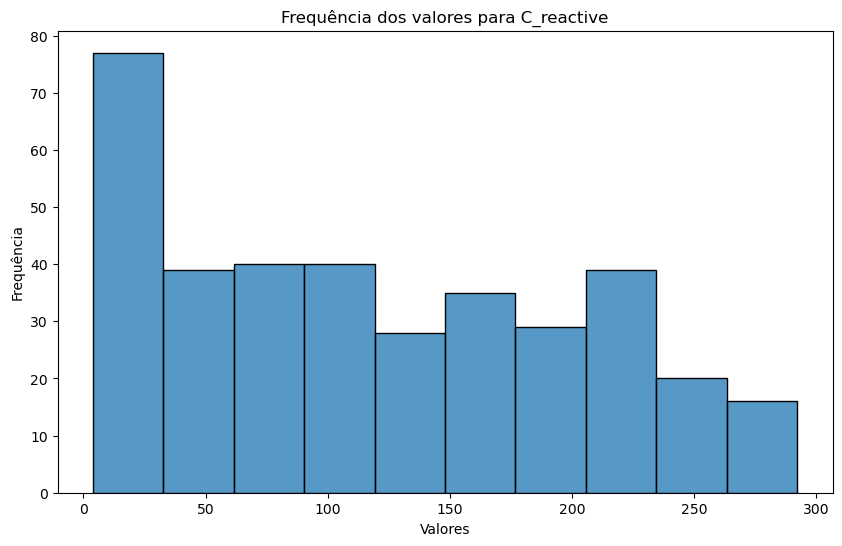

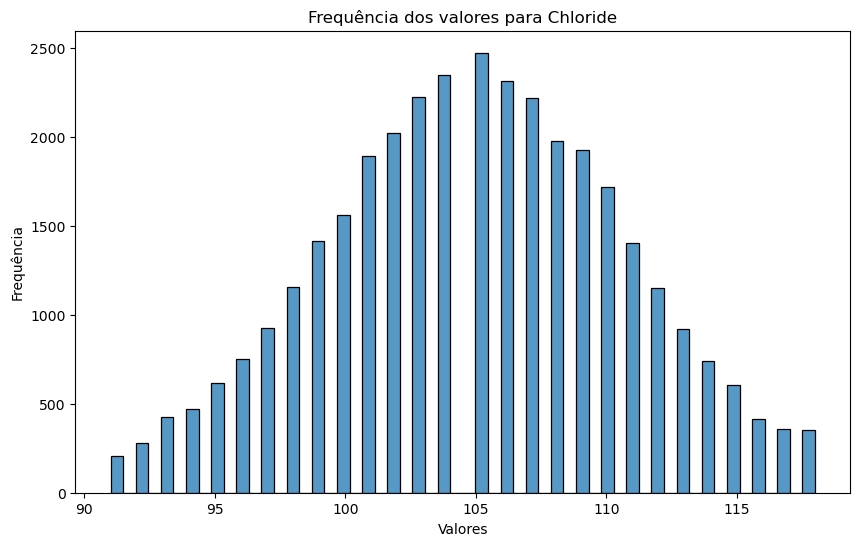

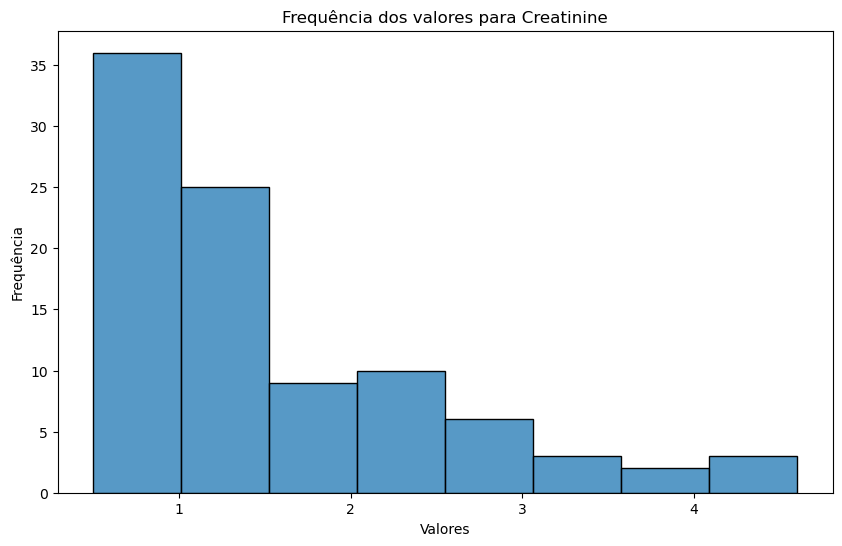

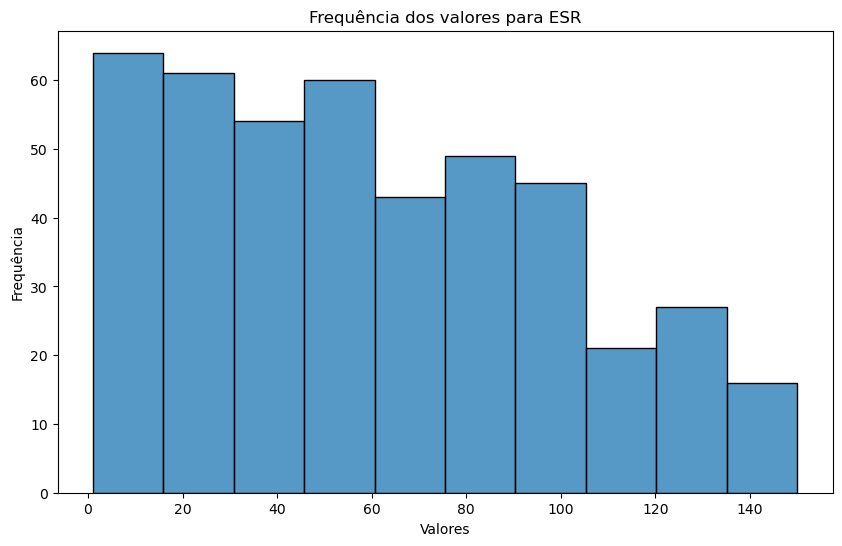

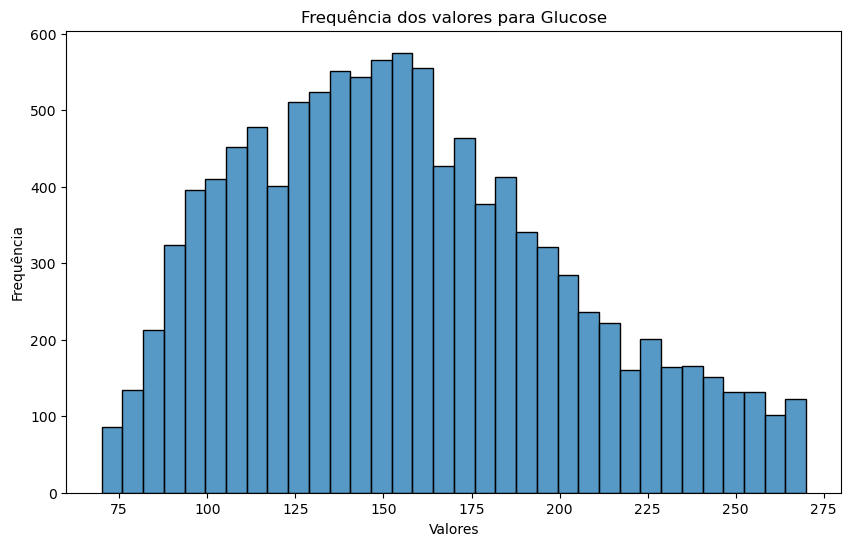

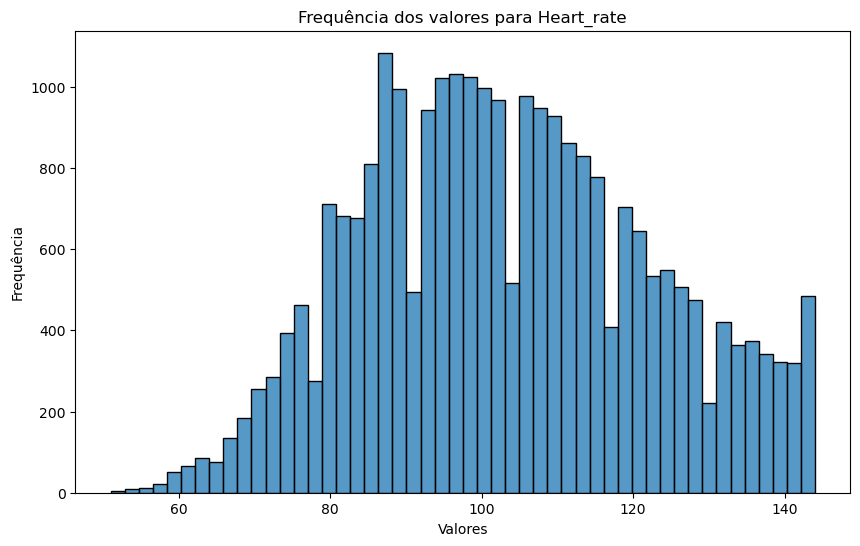

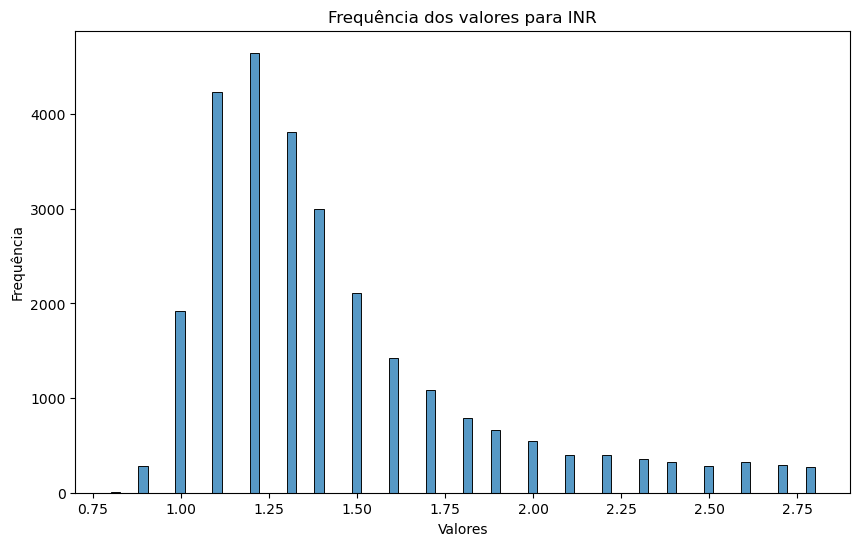

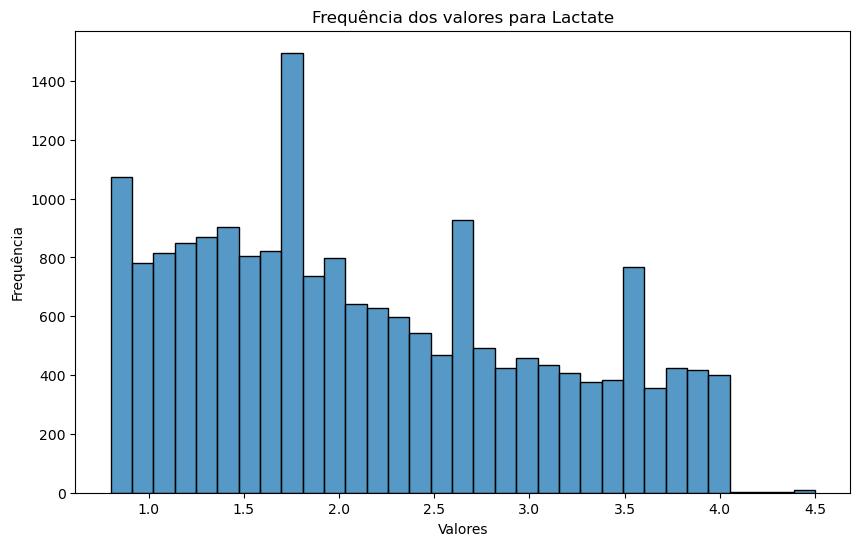

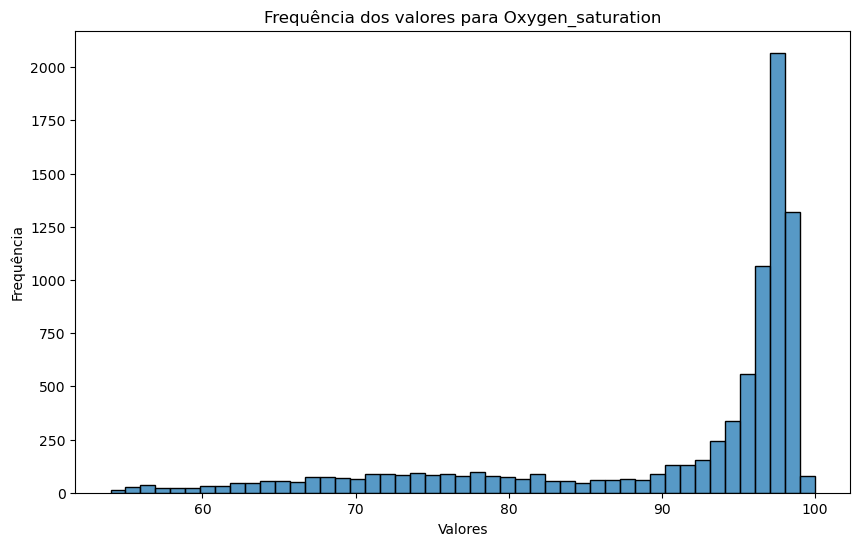

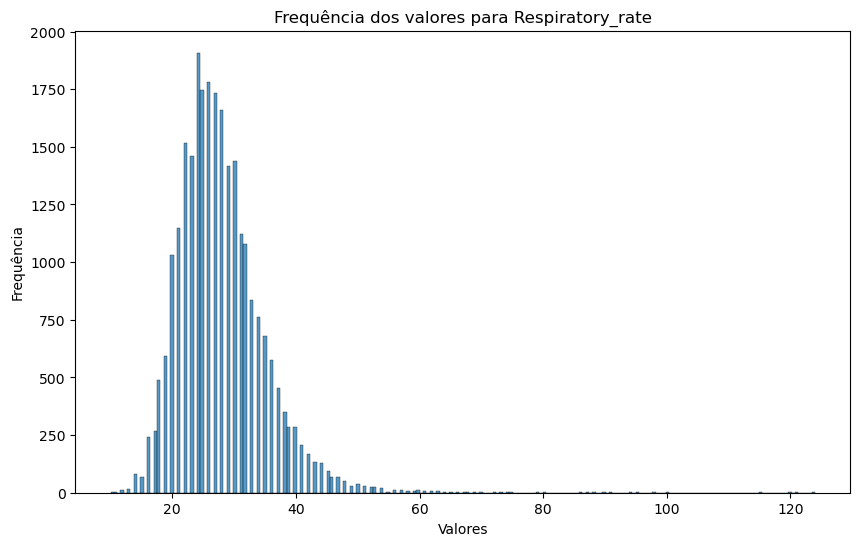

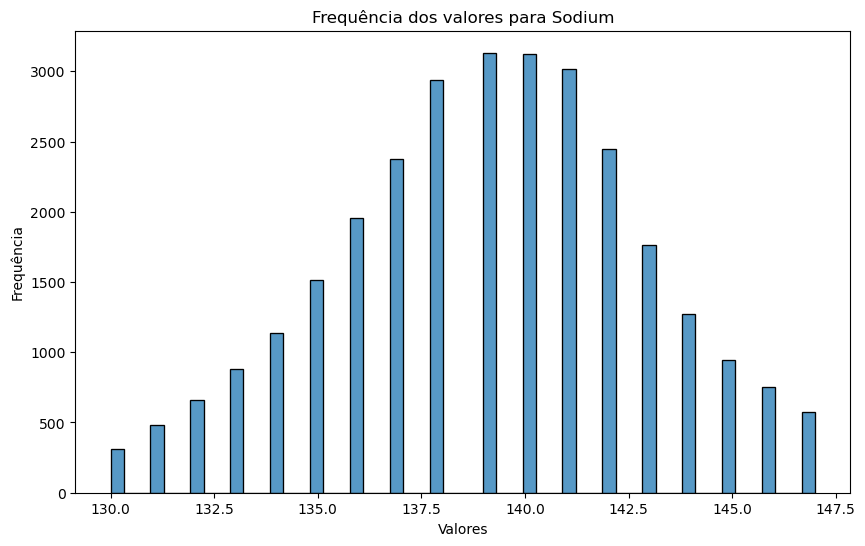

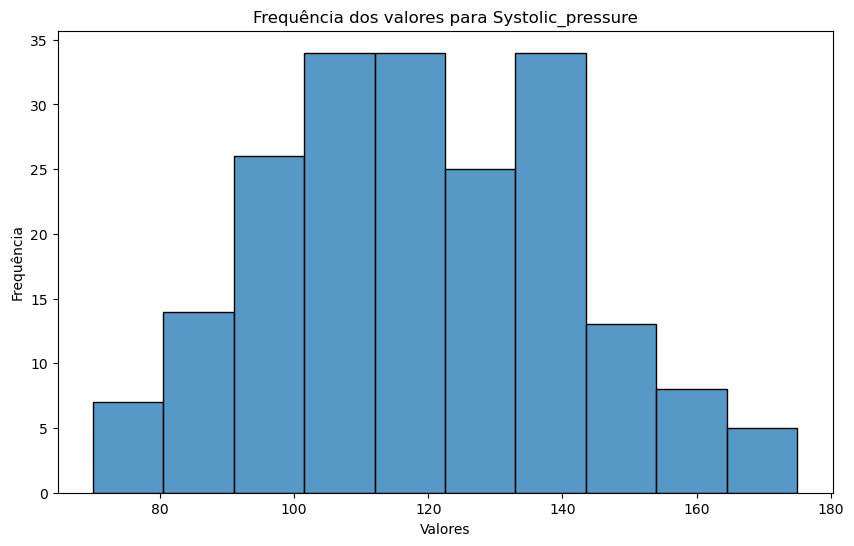

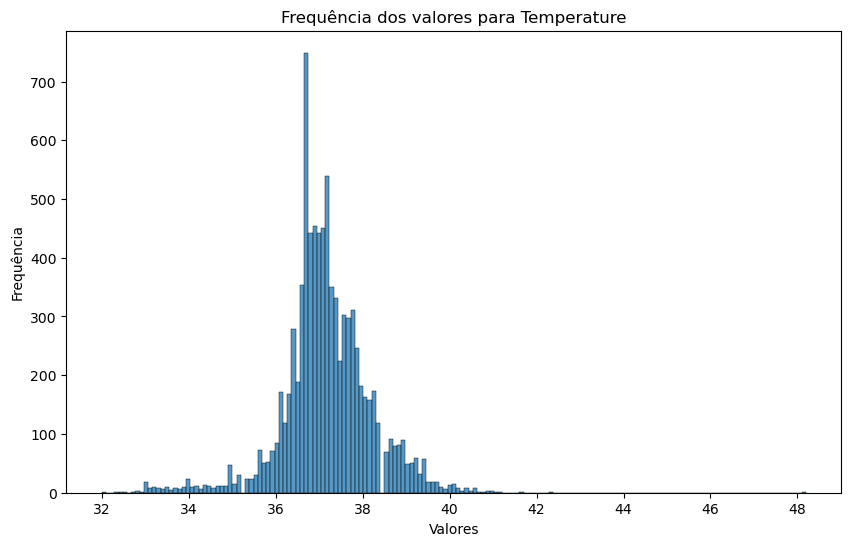

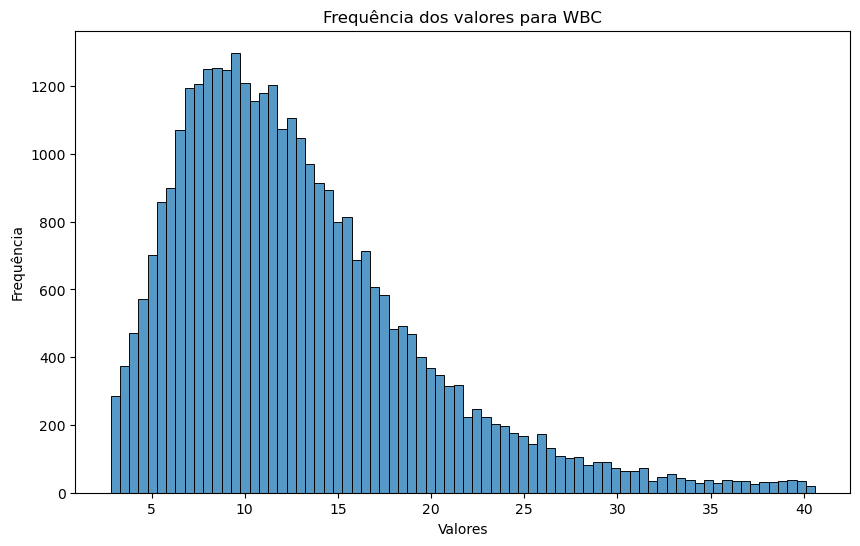

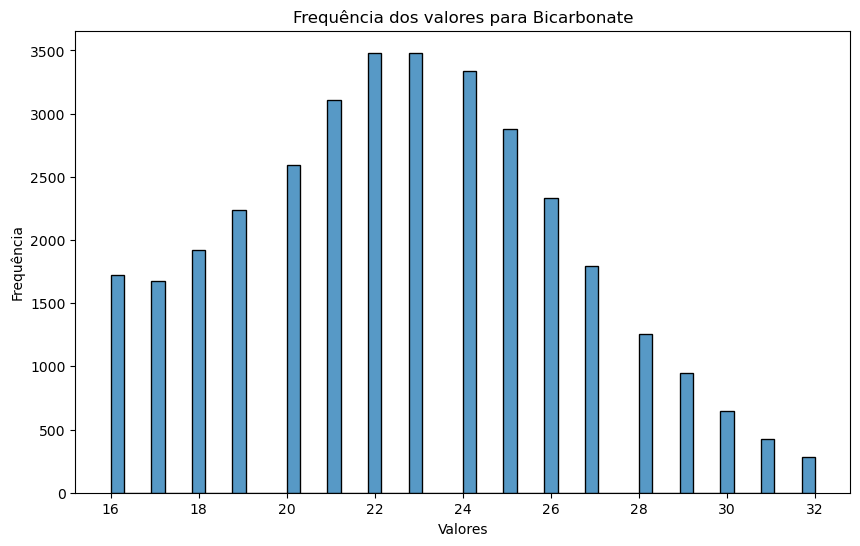

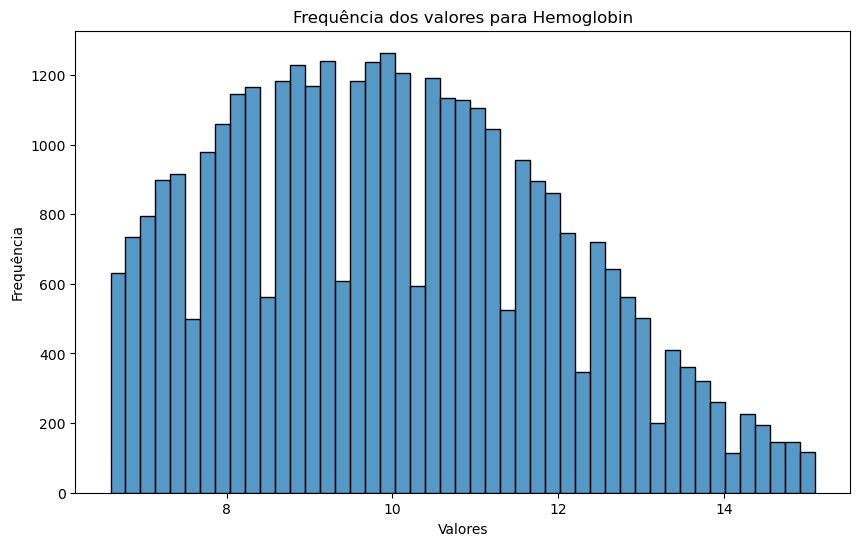

In [13]:
exams_columns = ['ALT', 'AST', 'Albumine', 'Bands', 'Bilirubin',
       'Bun', 'C_reactive', 'Chloride', 'Creatinine', 'ESR', 'Glucose',
       'Heart_rate', 'INR', 'Lactate', 'Oxygen_saturation', 'Respiratory_rate',
       'Sodium', 'Systolic_pressure', 'Temperature', 'WBC',
       'Bicarbonate', 'Hemoglobin']
# Criar gráficos de frequência para cada tipo de exame usando o loop for
for column in exams_columns:
    plt.figure(figsize=(10, 6))
    subset = worst_exams_24h[worst_exams_24h[column].notna()]
    sns.histplot(subset[column], kde=False)
    plt.title(f'Frequência dos valores para {column}')
    plt.xlabel('Valores')
    plt.ylabel('Frequência')
    plt.show()

In [14]:
sofa_24h = sofa.groupby(['subject_id', 'hadm_id'])['sofa_24hours'].max()
gcs_24h = sofa.groupby(['subject_id', 'hadm_id'])['gcs_min'].min()

In [15]:
worst_exams_24h_ = pd.merge(worst_exams_24h,sofa_24h,on = ['subject_id','hadm_id'],how = 'left')
worst_exams_24h_ = pd.merge(worst_exams_24h_,gcs_24h,on = ['subject_id','hadm_id'],how = 'left')

#### Matriz de correlação

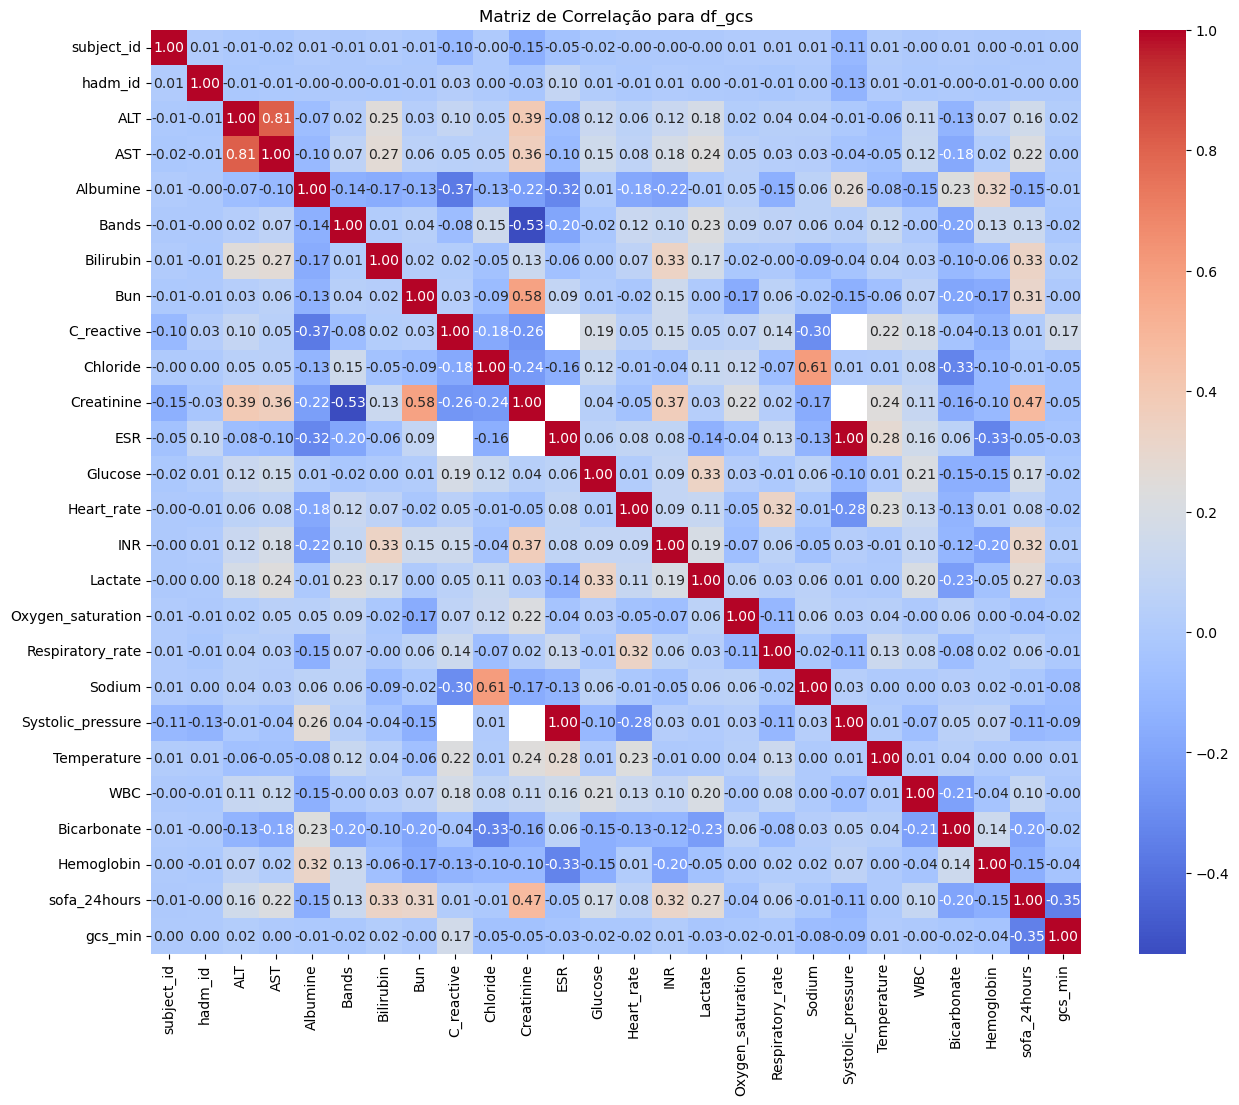

In [16]:
correlation_matrix = worst_exams_24h_.corr()

# Exibir a matriz de correlação usando um heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação para df_gcs')
plt.show()

In [17]:
worst_exams_24h_

,subject_id,hadm_id,ALT,AST,Albumine,Bands,Bilirubin,Bun,C_reactive,Chloride,...,Oxygen_saturation,Respiratory_rate,Sodium,Systolic_pressure,Temperature,WBC,Bicarbonate,Hemoglobin,sofa_24hours,gcs_min
0,10000826,21086876,33.0,105.0,3.1,NaN,1.4,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,20.0,30.0,10.7,NaN,NaN
1,10001401,27012892,NaN,NaN,NaN,NaN,NaN,34.0,NaN,106.0,...,NaN,NaN,NaN,NaN,NaN,16.5,22.0,9.8,NaN,NaN
2,10001401,27060146,NaN,NaN,NaN,NaN,NaN,24.0,NaN,99.0,...,NaN,NaN,137.0,NaN,NaN,18.8,23.0,7.5,NaN,NaN
3,10001884,26184834,47.0,37.0,NaN,NaN,0.2,16.0,NaN,94.0,...,NaN,NaN,135.0,NaN,NaN,6.6,30.0,11.4,4.0,15.0
4,10002013,23581541,NaN,NaN,NaN,NaN,NaN,16.0,NaN,109.0,...,99.0,23.0,140.0,NaN,37.7,20.2,23.0,10.2,4.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36576,19998878,26489544,35.0,71.0,2.8,NaN,NaN,21.0,NaN,103.0,...,NaN,19.0,134.0,NaN,NaN,6.8,19.0,10.8,8.0,15.0
36577,19999297,21439025,69.0,321.0,NaN,NaN,8.3,NaN,NaN,95.0,...,NaN,NaN,131.0,NaN,NaN,5.1,27.0,11.8,8.0,12.0
36578,19999442,26785317,NaN,NaN,NaN,NaN,NaN,12.0,NaN,107.0,...,NaN,24.0,141.0,NaN,NaN,12.1,23.0,13.9,4.0,10.0
36579,19999625,25304202,NaN,NaN,NaN,NaN,NaN,56.0,NaN,116.0,...,NaN,23.0,146.0,NaN,38.3,7.7,19.0,10.4,6.0,11.0


In [25]:
worst_exams_24h_.to_csv('worst_exams_24h.csv')

#### Piores exames do sofa

In [18]:
columns_exams_max = [
    'bilirubin_max',
    'creatinine_max',
    'liver_24hours',
    'cns_24hours',
    'renal_24hours',
    'sofa_24hours',
    'subject_id',
    'hadm_id'
]
columns_exams_min = [
    'pao2fio2ratio_novent',
    'pao2fio2ratio_vent',
    'platelet_min',
    'respiration_24hours',
    'coagulation_24hours',
    'cardiovascular_24hours',
    'meanbp_min',
    'subject_id',
    'hadm_id'
]

# Separate the DataFrame into max and min columns
sofa_max = sofa[columns_exams_max]
sofa_min = sofa[columns_exams_min]

In [19]:
sofa_min = sofa_min.groupby(['subject_id','hadm_id']).min()
sofa_max = sofa_max.groupby(['subject_id','hadm_id']).max()

In [20]:
sofa_worst_24h = pd.merge(sofa_max,sofa_min,on=['subject_id','hadm_id'],how = 'left')
sofa_worst_24h

bilirubin_max  creatinine_max  liver_24hours  \
subject_id hadm_id                                                  
10000032   29079034            NaN             0.5              0   
10000980   26913865            NaN             NaN              0   
10001217   24597018            NaN             0.4              0   
           27703517            NaN             0.5              0   
10001725   25563031            NaN             0.8              0   
...                            ...             ...            ...   
19999442   26785317            NaN             0.9              0   
19999625   25304202            NaN             2.5              0   
19999828   25744818            0.3             0.7              0   
19999840   21033226            NaN             0.8              0   
19999987   23865745            1.5             1.3              1   

                     cns_24hours  renal_24hours  sofa_24hours  \
subject_id hadm_id                                              
10000032   29079034            1              0             2   
10000980   26913865            0              0             0   
10001217   24597018            0              0             0   
           27703517            0              0             1   
10001725   25563031            0              0             1   
...                          ...            ...           ...   
19999442   26785317            2              0             4   
19999625   25304202            2              2             6   
19999828   25744818            1              0             1   
19999840   21033226            4              0             8   
19999987   23865745            2              1             8   

                     pao2fio2ratio_novent  pao2fio2ratio_vent  platelet_min  \
subject_id hadm_id                                                            
10000032   29079034                   NaN                 NaN           NaN   
10000980   26913865                   NaN                 NaN           NaN   
10001217   24597018                   NaN                 NaN         285.0   
           27703517                   NaN                 NaN         299.0   
10001725   25563031                   NaN                 NaN         299.0   
...                                   ...                 ...           ...   
19999442   26785317                   NaN          397.500000         121.0   
19999625   25304202                   NaN                 NaN         127.0   
19999828   25744818                   NaN                 NaN         368.0   
19999840   21033226                   NaN          110.909091         236.0   
19999987   23865745                   NaN          285.000000         121.0   

                     respiration_24hours  coagulation_24hours  \
subject_id hadm_id                                              
10000032   29079034                    0                    0   
10000980   26913865                    0                    0   
10001217   24597018                    0                    0   
           27703517                    0                    0   
10001725   25563031                    0                    0   
...                                  ...                  ...   
19999442   26785317                    0                    1   
19999625   25304202                    0                    0   
19999828   25744818                    0                    0   
19999840   21033226                    2                    0   
19999987   23865745                    0                    0   

                     cardiovascular_24hours  meanbp_min  
subject_id hadm_id                                       
10000032   29079034                       1        56.0  
10000980   26913865                       0        83.0  
10001217   24597018                       0        80.0  
           27703517                       0        66.0  
10001725   25563031                       1        54.0

In [21]:
patients = worst_exams_24h[['subject_id','hadm_id']]
sofa_worst_24h = pd.merge(patients,sofa_worst_24h,on=['subject_id','hadm_id'],how = 'left')

In [22]:
exams_columns = [ 'bilirubin_max', 'creatinine_max',
       'liver_24hours', 'cns_24hours', 'renal_24hours', 'sofa_24hours',
       'pao2fio2ratio_novent', 'pao2fio2ratio_vent', 'platelet_min',
       'respiration_24hours', 'coagulation_24hours', 'cardiovascular_24hours']

#### Visualizando valores

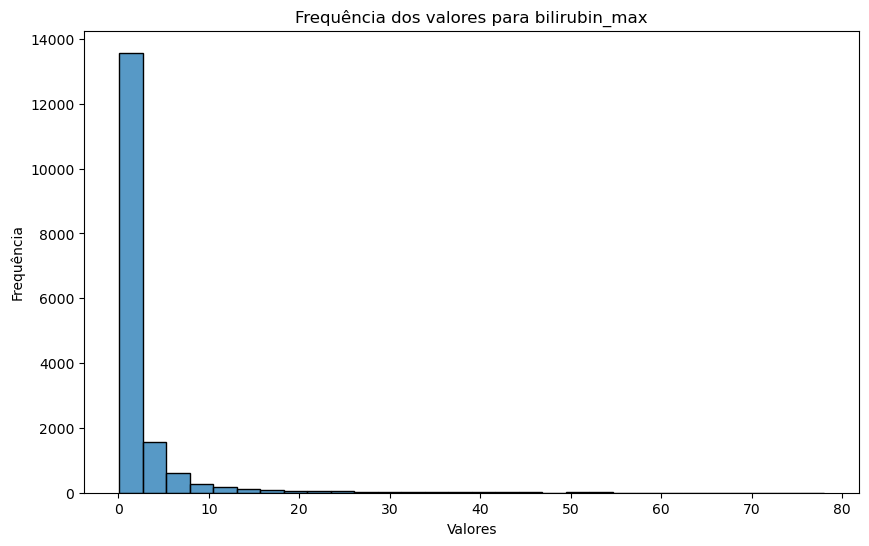

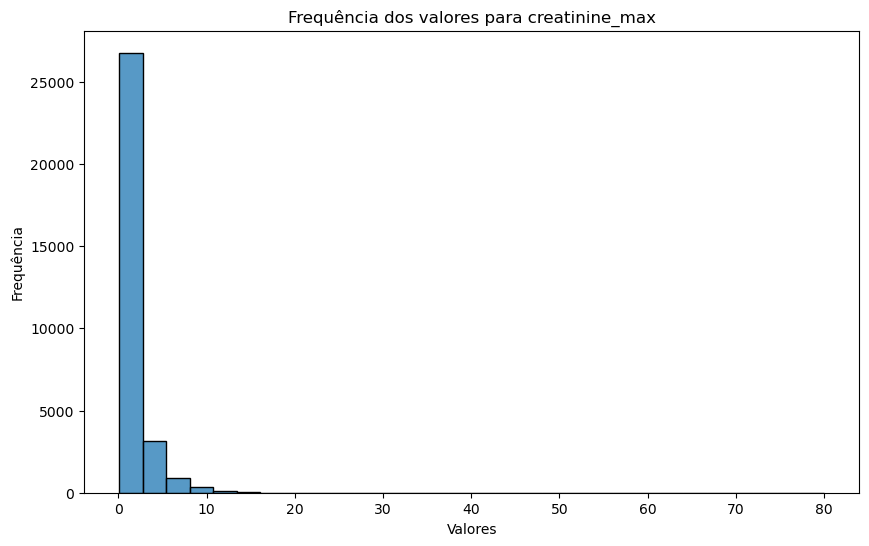

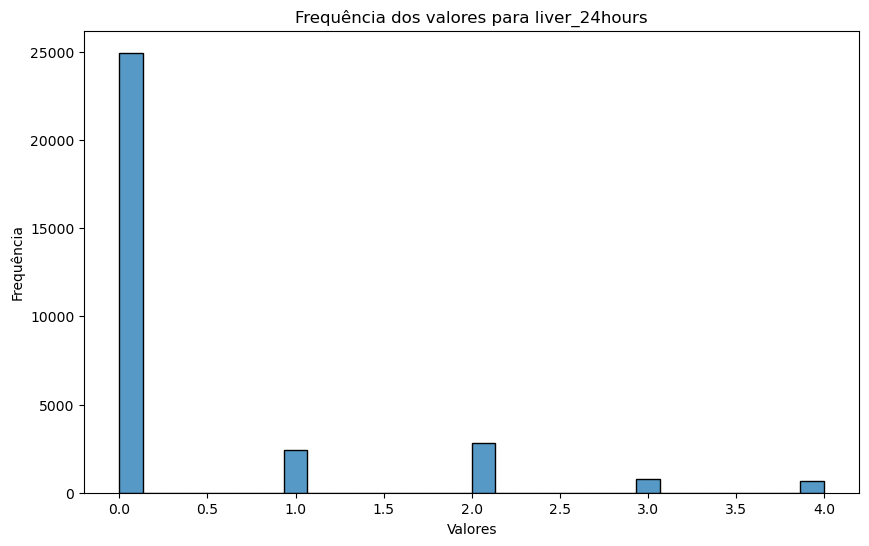

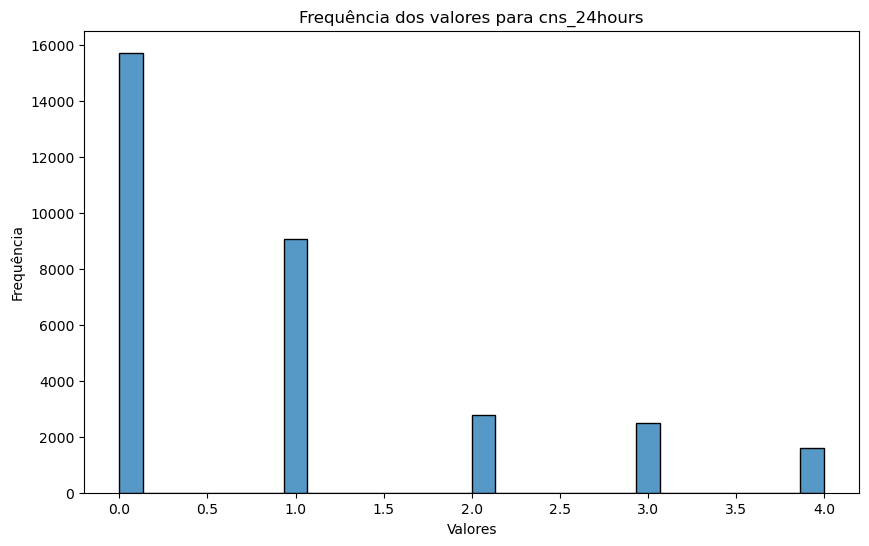

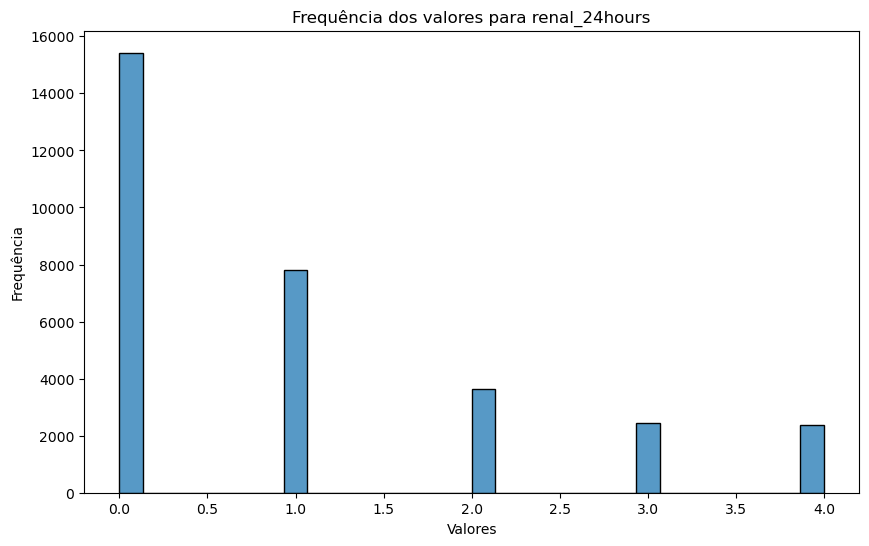

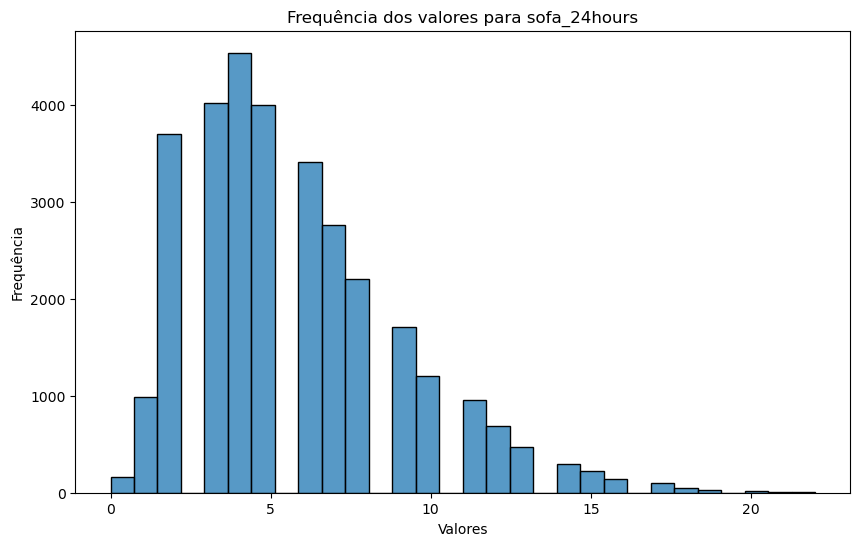

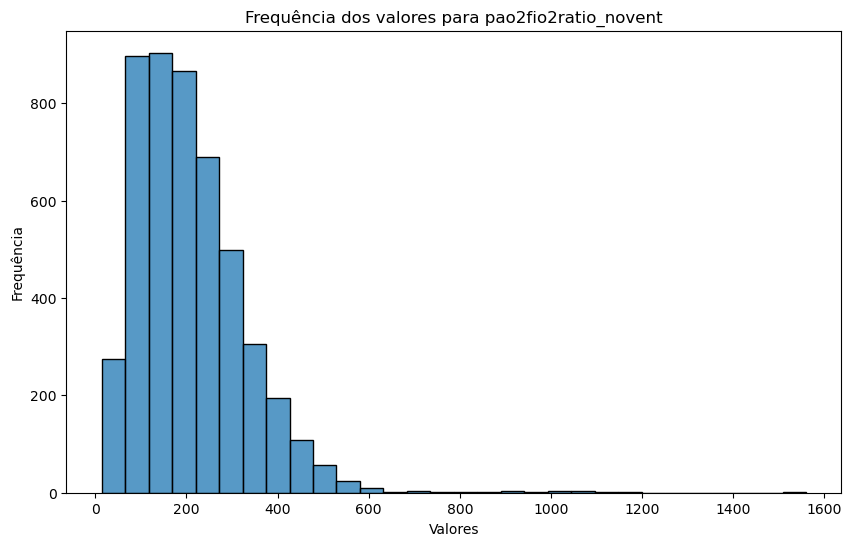

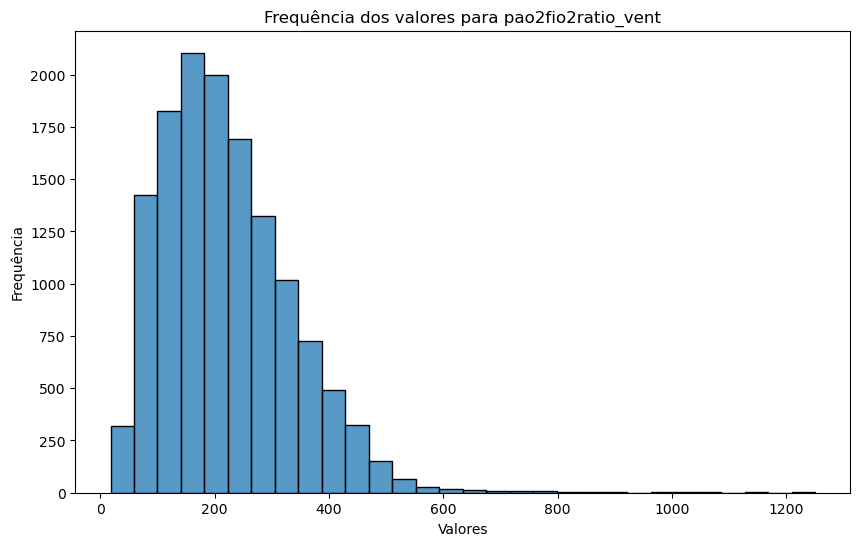

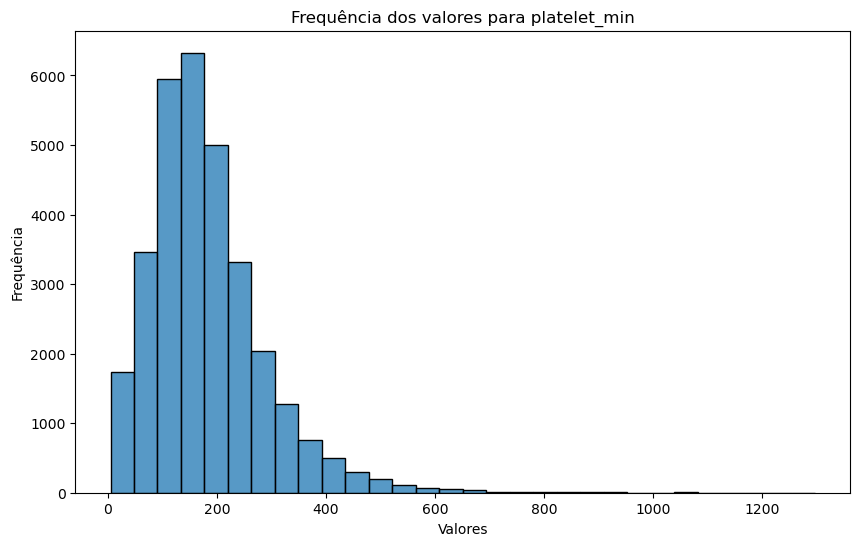

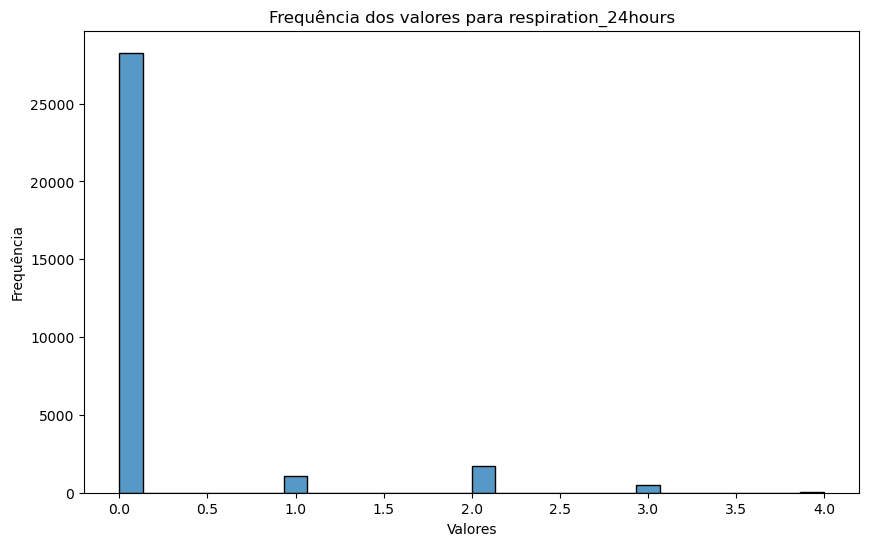

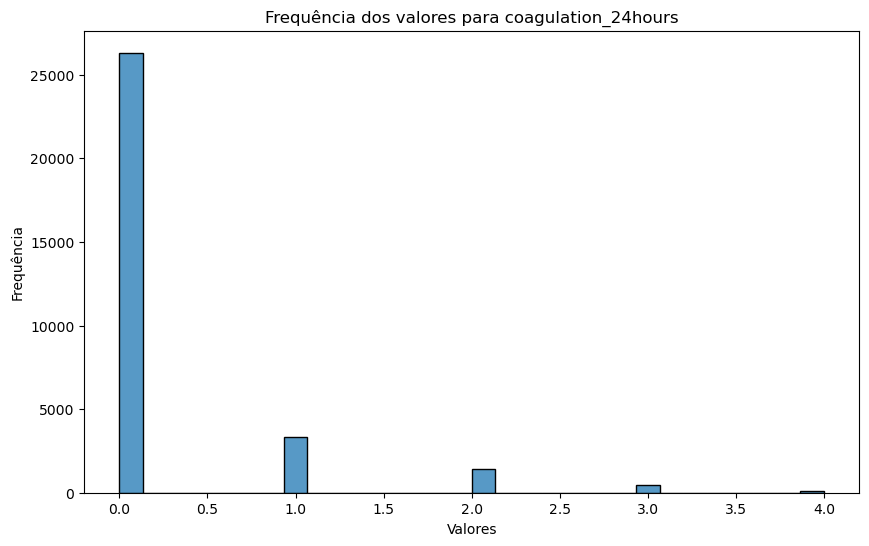

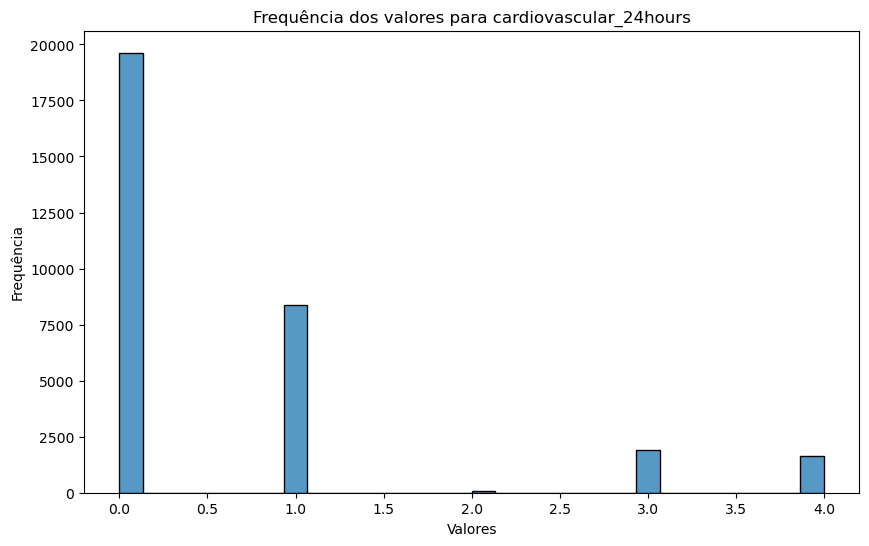

In [23]:
for column in exams_columns:
    plt.figure(figsize=(10, 6))
    subset = sofa_worst_24h[sofa_worst_24h[column].notna()]
    sns.histplot(subset[column], kde=False, bins=30)
    plt.title(f'Frequência dos valores para {column}')
    plt.xlabel('Valores')
    plt.ylabel('Frequência')
    plt.show()

In [24]:
sofa_worst_24h.to_csv('sofa_worst_24h.csv')

In [44]:
patients = patients[[ 'gender', 'anchor_age','subject_id']]
admissions = admissions[['admission_type', 'marital_status', 'race','subject_id','hadm_id']]
admissions = pd.merge(admissions,patients,on = 'subject_id',how = 'left')

In [46]:
all_worst  = pd.merge(worst_exams_24h,sofa_worst_24h,on =['subject_id',	'hadm_id'],how = 'left')
all_worst = pd.merge(all_worst,worst_exams_24h_[['subject_id',	'hadm_id','gcs_min']],on =['subject_id',	'hadm_id'],how = 'left')
all_worst = pd.merge(all_worst,admissions,on =['subject_id','hadm_id'],how = 'left')

In [48]:
all_worst = all_worst[[ 'subject_id', 'hadm_id', 'ALT', 'AST', 'Albumine',
       'Bands', 'Bilirubin', 'Bun', 'C_reactive', 'Chloride', 'Creatinine',
       'ESR', 'Glucose', 'Heart_rate', 'INR', 'Lactate', 'Oxygen_saturation',
       'Respiratory_rate', 'Sodium', 'Systolic_pressure', 'Temperature', 'WBC',
       'Bicarbonate', 'Hemoglobin', 'sofa_24hours', 'gcs_min',
       'admission_type', 'marital_status', 'race', 'gender', 'anchor_age',
       'bilirubin_max', 'creatinine_max', 'liver_24hours', 'cns_24hours',
       'renal_24hours', 'pao2fio2ratio_novent', 'pao2fio2ratio_vent',
       'platelet_min', 'respiration_24hours', 'coagulation_24hours',
       'cardiovascular_24hours']]

In [49]:
all_worst.to_csv('all_worst.csv',index=False)